### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 10th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [38]:
import numdifftools as nd
import numpy as np 
import scipy
import matplotlib.pyplot as plt
from scipy import optimize


In [ ]:
# For later:
# H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
# sigma_laplace = np.linalg.inv(H)**0.5

### Solution

# 1

In [7]:
data = np.load('../../../homeworks/hw_data/hw3_data_1.npy')

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$


In [16]:
def het_mean_sigma_analytic(data):
    '''
    A function to analytically calculate the mean and uncert on mean for 
    a heteroscedastic dataset

    inputs:
    data (ndarray): N measurements x 2 array where [:, 1] are the uncertainties

    returns:
    mean (float): mean analytically calculated for heteroscedastic data
    sigmu (float): uncertainty on the mean analytically calc.
    '''
    numerator = np.sum(data[:, 0] / data[:, 1]**2) # LSS sum of measurement over
    # the square of the respective uncertainties
    denom = np.sum(data[:, 1]**-2) # LSS sum of the inverse square of the uncert.

    mean = numerator / denom

    sigmu = denom**-0.5 # LSS uncert on mean is denominator to the -0.5
    return mean, sigmu

In [17]:
datamean_an, datasigmu_an = het_mean_sigma_analytic(data)

In [21]:
print(f'analytically calculated mu={datamean_an:.2f}, sigma_mu={datasigmu_an:.2f}')

analytically calculated mu=3.92, sigma_mu=0.09


# 2

In [95]:
def chisq(mu_model, sigma_model, data, uncert, plot=False):
    '''
    A function to return the chi squared for data when modeled by a 
    gaussian with mu=mu_model, sigma=sigma_model. 

    inputs:
    mu_model (float): mean for the gaussian model
    sigma_model (float): sigma for the gaussian model
    data (ndarray): the data to be fit to 
    uncert (ndarray): the uncert for each data point
    outputs:
    chisq (float): negative log likelihood for some mu_model and sigma_model
    '''
    # LSS defining gaussian from inputs
    gaussmodel = scipy.stats.norm(mu_model, sigma_model)
    # LSS calculating likelihood
    chisq = 0.5 * np.sum((data - gaussmodel.rvs(data.shape[0]))**2 / uncert**2, -1)

    # LSS scratch work below
    # xgrid = np.linspace(np.min(data)-5*sigma_model, np.max(data)+5*sigma_model, 1000)
    # neglnlik = -0.5 * np.sum((data - gaussmodel.pdf())**2 / uncert**2)

    # LSS plotting for visualization purposes
    if plot:
        xgrid = np.linspace(np.min(data)-5*sigma_model,np.max(data)+5*sigma_model,1000) # Array to sample the space 
        distG = scipy.stats.norm(mu_model, sigma_model) # Complete
        plt.plot(xgrid, distG.pdf(xgrid)) # Complete

        plt.errorbar(data, 0*data, xerr=uncert, marker='|')
        plt.hist(data, density=True, histtype='step')
        plt.xlabel('x')
        plt.ylabel('pdf')
    return chisq

899.0349903520153

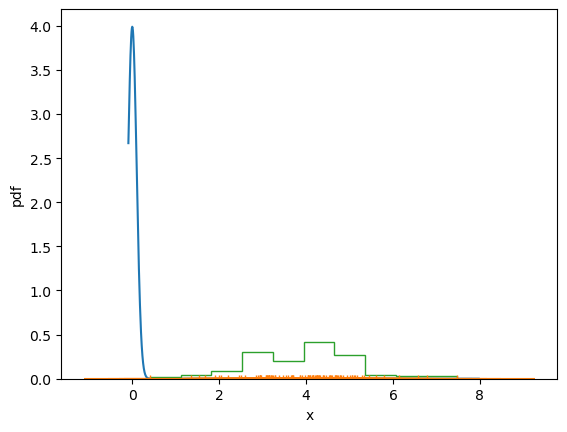

In [98]:
chisq(0, .1, data[:, 0], data[:, 1], plot=True)

In [105]:
neglnlik_heterodata = lambda modelguess: chisq(modelguess[0], modelguess[1], 
                                                  data=data[:, 0], uncert=data[:, 1])
modelguess0 = [2, 1]
bestfitmodel = optimize.fmin(neglnlik_heterodata, modelguess0)

/var/folders/1y/5f87nyls7mnbqvgd2zgz0lmc0000gr/T/ipykernel_16955/1360939815.py:4: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  bestfitmodel = optimize.fmin(neglnlik_heterodata, modelguess0)


In [106]:
print(f'chi squared minimization best fit mean={bestfitmodel[0]:.2f}, sigma={bestfitmodel[1]:.2f}')

chi squared minimization best fit mean=1.89, sigma=1.06


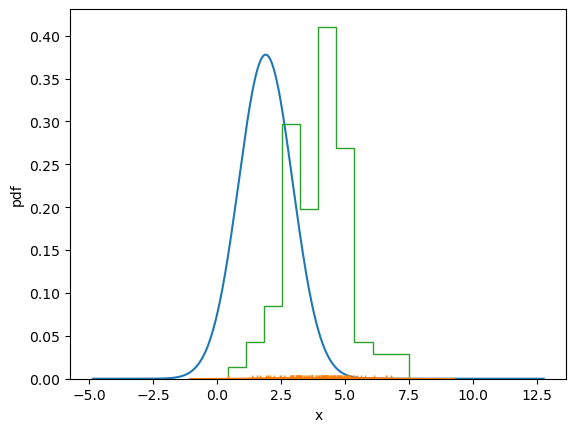

In [108]:
chisq(bestfitmodel[0], bestfitmodel[1], data[:,0], data[:,1], plot=True);